In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup

# Global Variables
DUMMY_USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_5) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.102 Safari/537.36'
MAX_HOLDERS_SHOWN = 1000
MAX_HOLDERS_PER_PAGE = 50
MAX_PAGES = int(MAX_HOLDERS_SHOWN / MAX_HOLDERS_PER_PAGE)

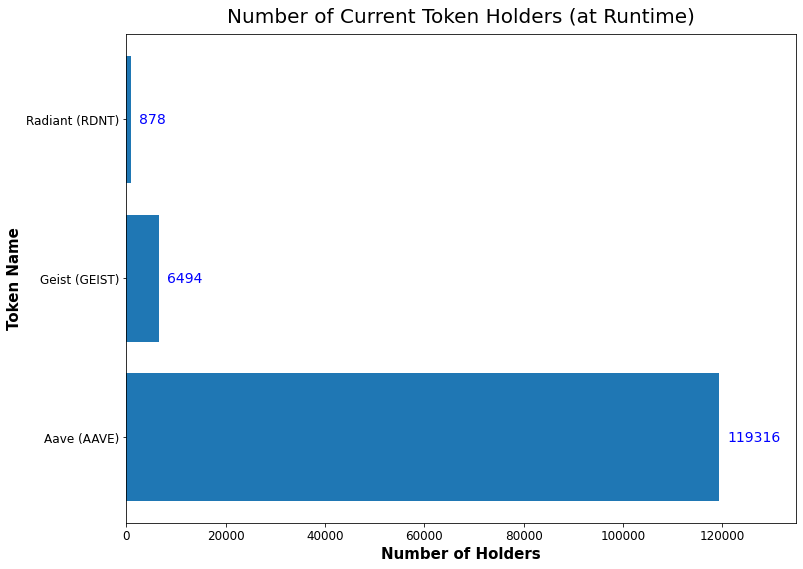

In [2]:
## Plot the number of holders for each token

# Blockchain explorer URLs
aave_token_url = 'https://etherscan.io/token/0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9#balances'
geist_token_url = 'https://ftmscan.com/token/0xd8321aa83fb0a4ecd6348d4577431310a6e0814d#balances'
radiant_token_url = 'https://arbiscan.io/token/0x0c4681e6c0235179ec3d4f4fc4df3d14fdd96017#balances'

# Get the HTML for each token
# Note: Requests to Etherscan will fail if the User-Agent header is missing
aave_token_html = BeautifulSoup(requests.get(aave_token_url, headers={'User-Agent': DUMMY_USER_AGENT}).text, 'html.parser')
geist_token_html = BeautifulSoup(requests.get(geist_token_url).text, 'html.parser')
radiant_token_html = BeautifulSoup(requests.get(radiant_token_url).text, 'html.parser')

# Scrape the number of holders from the html
aave_number_of_holders = int(aave_token_html.find(id="ContentPlaceHolder1_tr_tokenHolders").find('div', {'class': 'mr-3'}).text.split(' ')[0].split('\n')[1].replace(',',''))
geist_number_of_holders = int(geist_token_html.find(id="ContentPlaceHolder1_tr_tokenHolders").find('div', {'class': 'col-md-8'}).text.split(' ')[0].split('\n')[1].replace(',',''))
radiant_number_of_holders = int(radiant_token_html.find(id="ContentPlaceHolder1_tr_tokenHolders").find('div', {'class': 'mr-3'}).text.split(' ')[36])
    
# Create a dictionary to store the number of holders 
number_of_holders = {
    'Aave': aave_number_of_holders,
    'Geist': geist_number_of_holders,
    'Radiant': radiant_number_of_holders
}

token_names = {
    'Aave': 'Aave (AAVE)',
    'Geist': 'Geist (GEIST)',
    'Radiant': 'Radiant (RDNT)'
}

# Figure Size
fig, ax = plt.subplots(figsize =(12, 9))
 
# Horizontal Bar Plot
bar_container = ax.barh(list(token_names.values()), list(number_of_holders.values()))

# Add Plot Title
ax.set_title(
    'Number of Current Token Holders (at Runtime)',
    fontdict={
        'fontsize': 20
    },
    loc='center',
    pad=12
)

# Label Axes
plt.xlabel('Number of Holders', fontweight ='bold', fontsize = 15)
plt.ylabel('Token Name', fontweight ='bold', fontsize = 15)

# Set Tick Size
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add Bar Labels
plt.bar_label(bar_container, padding=8, color='b', fontsize=14)

# Add Padding on X Axis to Make Room for Bar Labels 
plt.axis(xmax=max([aave_number_of_holders, geist_number_of_holders, radiant_number_of_holders])*1.13)

# Show Plot
plt.show()

In [ ]:
aave_holders_raw = pd.read_csv('aave-token-holders.csv')
geist_holders_raw = pd.read_csv('geist-token-holders.csv')
radiant_holders_raw = pd.read_csv('radiant-token-holders.csv')

# Clean Data (Part I)
# Remove rows with the zero address
aave_holders_first_clean = aave_holders_raw[aave_holders_raw['HolderAddress'] != '0x0000000000000000000000000000000000000000']
geist_holders_first_clean = geist_holders_raw[geist_holders_raw['HolderAddress'] != '0x0000000000000000000000000000000000000000']
radiant_holders_first_clean = radiant_holders_raw[radiant_holders_raw['HolderAddress'] != '0x0000000000000000000000000000000000000000']

# Clean Data (Part II)
# Remove rows with zero balance
aave_holders = aave_holders_first_clean[aave_holders_first_clean['Balance'] != 0]
geist_holders = geist_holders_first_clean[geist_holders_first_clean['Balance'] != 0]
radiant_holders = radiant_holders_first_clean[radiant_holders_first_clean['Balance'] != 0]

In [19]:
aave_number_of_institutional_holders = 0
aave_holders_page_number = 1

aave_holders_base_url = 'https://etherscan.io/token/generic-tokenholders2?a=0x7fc66500c84a76ad7e9c93437bfc5ac33e2ddae9&sid=&m=normal&s=16000000000000000000000000'

# Make http request
# If the status code is 200
    # Find the element with the id 'maintable'
    # If the element exists
        # Loop across the table
    # Else
        # Break the loop
    # Increment the page number
    # Make the http request
    # If the status code is 200
        # Find the element with the id 'maintable'

# Request the first page of token holders
aave_holders_request = requests.get(aave_holders_base_url + '&p=' + str(aave_holders_page_number), headers={'User-Agent': DUMMY_USER_AGENT})

# If the status code is 200
# Note that a 200 status code does not guarantee a table of token holders
if aave_holders_request.status_code == 200:
    
    # Find the element with the id 'maintable'
    main_table = BeautifulSoup(aave_holders_request.text, 'html.parser').find(id='maintable')
    
    # The the table column which stores the wallet address 
    ETHEREUM_ADDRESS_COULMN = 1
    
    while main_table is not None:
        # Parse table
        print('Parsing Aave data table on webpage ' + str(aave_holders_page_number))
        
        # HTML table rows
        rows = main_table.find_all('tr')
        
        # For each row
        for row in range(1,len(rows)):
            # Grab the html element that contains the wallet data
            wallet_address_element = rows[row].find_all('td')[ETHEREUM_ADDRESS_COULMN]
            
            # Extract the wallet address
            wallet_address = wallet_address_element.find('a').string
            
            # If a hex string is not provided
            if not wallet_address.startswith('0x'):
                # Increment the number of institutional holders
                aave_number_of_institutional_holders += 1
                
        print(str(aave_number_of_institutional_holders) + ' total institutional wallet addresses up to page ' + str(aave_holders_page_number))

        # Increment the page number
        aave_holders_page_number += 1

        # Make the http request
        aave_holders_request = requests.get(aave_holders_base_url + '&p=' + str(aave_holders_page_number), headers={'User-Agent': DUMMY_USER_AGENT})

        # If the status code is 200
        if aave_holders_request.status_code == 200:
            # Find the element with the id 'maintable'
            main_table = BeautifulSoup(aave_holders_request.text, 'html.parser').find(id='maintable')
        else:
            print('Received bad status code for AAVE holders page ' + str(aave_holders_page_number))
            
            # Set the main table to None
            main_table = None
            
            # Break the while loop
            break
    
    print('Completed parsing all Aave data tables')
        
else:
    print('Received bad status code for AAVE holders page ' + str(aave_holders_page_number))




Parsing Aave data table on webpage 1
24 institutional wallet addresses up to page 1
Parsing Aave data table on webpage 2
35 institutional wallet addresses up to page 2
Parsing Aave data table on webpage 3
43 institutional wallet addresses up to page 3
Parsing Aave data table on webpage 4
51 institutional wallet addresses up to page 4
Parsing Aave data table on webpage 5
55 institutional wallet addresses up to page 5
Parsing Aave data table on webpage 6
59 institutional wallet addresses up to page 6
Parsing Aave data table on webpage 7
63 institutional wallet addresses up to page 7
Parsing Aave data table on webpage 8
69 institutional wallet addresses up to page 8
Parsing Aave data table on webpage 9
72 institutional wallet addresses up to page 9
Parsing Aave data table on webpage 10
77 institutional wallet addresses up to page 10
Parsing Aave data table on webpage 11
81 institutional wallet addresses up to page 11
Parsing Aave data table on webpage 12
87 institutional wallet addresses 